In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal
import seaborn as sns

In [2]:
a = np.array([-.3, .5])

beta = (1/.2)**2  # Precision parameter (noise variance)
alpha = 2.  # precision of prior 

In [3]:
def get_y(x, a):
    return a[0] + a[1] * x

In [4]:
def generate_synthetic_data(a, beta, n=1):
    x = np.random.uniform(-1, 1, n)
    t = get_y(x, a) + np.random.normal(0, 1/ np.sqrt(beta))
    return x, t

In [5]:
generate_synthetic_data(a,1)

(array([0.31745349]), array([-1.34091456]))

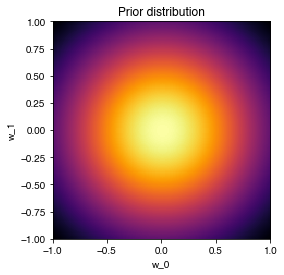

In [6]:
# plot the prior 
w0, w1 = np.mgrid[-1:1:.01, -1:1:.01]
pos = np.empty(w0.shape + (2,))
pos[:, :, 0] = w0; pos[:, :, 1] = w1
rv = multivariate_normal([0, 0], (1/ alpha) * np.eye(2))

plt.imshow(rv.pdf(pos), extent=[-1, 1, -1 ,1], cmap='inferno')

plt.title('Prior distribution')

plt.xlabel('w_0')
plt.ylabel('w_1')

In [7]:
samples = rv.rvs(6)

(-1, 1)

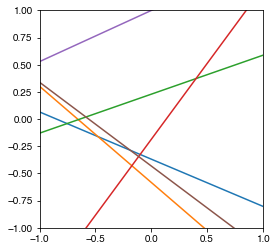

In [8]:
plt.figure(figsize=[4,4])

x = np.linspace(-1, 1, 50)

for s in samples:
    plt.plot(x, s[0] + x * s[1])

plt.xlim([-1,1])
plt.ylim([-1,1])

In [9]:
# Now we observe a single data point 
x, t = generate_synthetic_data(a, beta, 1)

In [10]:
# We can therefore evaluate the likelihood function p(t| x, w)

In [11]:
def likelihood_func(t, x, w, beta):
    rv = multivariate_normal(get_y(x, w), 1/beta)
    return rv.pdf(t)

In [12]:
likelihood_mat = np.empty(w1.shape)
for i, wx in enumerate(w1[0]):
    for j, wy in enumerate(w1[0]):
        likelihood = likelihood_func(t[0], x[0], np.array([wx, wy]), beta)
        likelihood_mat[i, j] = likelihood

In [13]:
likelihood_mat.shape

(200, 200)

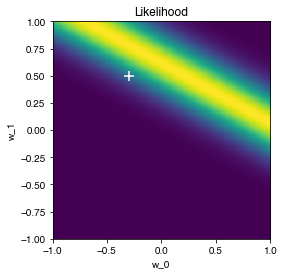

In [14]:
plt.imshow(likelihood_mat, extent=[-1, 1, -1, 1])

plt.scatter(a[0], a[1], marker='+', c='white', s=100)
plt.title('Likelihood')


plt.xlabel('w_0')
plt.ylabel('w_1')

In [15]:
# Now, we want to compute a posterior distribution by multiplying the likelihood function by the prior, 
# and normalising. 

In [16]:
# plot the posterior 

# new parameters (can just update parameters because we use a conjugate prior)
S_N_inv = alpha * np.eye(2) + beta * np.outer(np.array([1, x]), np.array([1, x]))
S_N = np.linalg.inv(S_N_inv)
m = beta * np.matmul(S_N, np.array([1,x])) * t

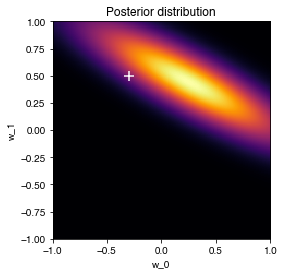

In [17]:
w0, w1 = np.mgrid[-1:1:.01, -1:1:.01]
pos = np.empty(w0.shape + (2,))
pos[:, :, 0] = w0; pos[:, :, 1] = w1
rv = multivariate_normal(m, S_N)

plt.imshow(rv.pdf(pos), extent=[-1, 1, -1 ,1], cmap='inferno')
plt.scatter(a[0], a[1], marker='+', c='white', s=100)


plt.title('Posterior distribution')

plt.xlabel('w_0')
plt.ylabel('w_1')

In [18]:
posterior_samples = rv.rvs(6)

(-1, 1)

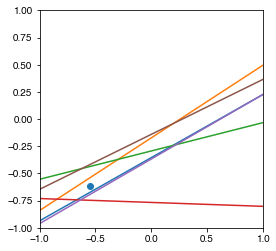

In [19]:
plt.figure(figsize=[4,4])

xs = np.linspace(-1, 1, 50)

for s in posterior_samples:
    plt.plot(xs, s[0] + xs * s[1])

plt.scatter(x, t, marker='o')    

plt.xlim([-1,1])
plt.ylim([-1,1])

In [20]:
# Now we observe a second data point

In [21]:
# Now we observe a single data point 
x2, t2 = generate_synthetic_data(a, beta, 1)

# the posterior of the past trial is now the prior:
S_N_inv_prior = S_N_inv
S_N_prior = S_N
m_prior = m

In [22]:
likelihood_mat = np.empty(w1.shape)
for i, wx in enumerate(w1[0]):
    for j, wy in enumerate(w1[0]):
        likelihood = likelihood_func(t2[0], x2[0], np.array([wx, wy]), beta)
        likelihood_mat[i, j] = likelihood

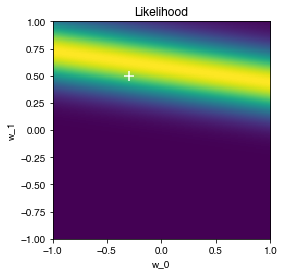

In [23]:
plt.imshow(likelihood_mat, extent=[-1, 1, -1, 1])

plt.scatter(a[0], a[1], marker='+', c='white', s=100)
plt.title('Likelihood')


plt.xlabel('w_0')
plt.ylabel('w_1')

In [24]:
# new parameters (can just update parameters because we use a conjugate prior)
S_N_inv = S_N_inv_prior + beta * np.outer(np.array([1, x2]), np.array([1, x2]))
S_N = np.linalg.inv(S_N_inv)
m = np.matmul(S_N, np.matmul(S_N_inv_prior, m_prior) + beta * np.array([1, x2]) * t2)

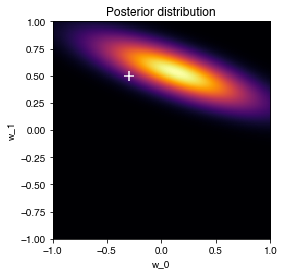

In [25]:
rv = multivariate_normal(m, S_N)

plt.imshow(rv.pdf(pos), extent=[-1, 1, -1 ,1], cmap='inferno')
plt.scatter(a[0], a[1], marker='+', c='white', s=100)

plt.title('Posterior distribution')

plt.xlabel('w_0')
plt.ylabel('w_1')

In [26]:
posterior_samples = rv.rvs(6)

(-1, 1)

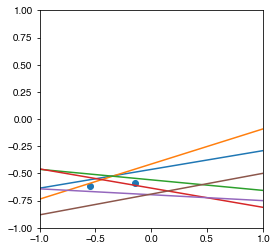

In [27]:
plt.figure(figsize=[4,4])

xs = np.linspace(-1, 1, 50)

for s in posterior_samples:
    plt.plot(xs, s[0] + xs * s[1])

plt.scatter([x, x2], [t, t2], marker='o')    

plt.xlim([-1,1])
plt.ylim([-1,1])

Of course we're not actually interested in the value of w itself but rather in making predictions of t for new values of x. Therefore we need to evaluate the *predictive* distribution.

Turns out the predictive distribution is also a gaussian because of result 2.115 in Bishop (convolution of two Gaussian distributions). 

In [28]:
# evaluate predictive distribution. 



means = []
variances = [] 
for x in xs:

    phi = np.array([1, x])

    predictive_mean = np.dot(m, phi)
    predictive_var = 1 / beta + np.dot(phi, np.matmul(S_N, phi))

    #predictive_dist = multivariate_normal(predictive_mean, predictive_var)
    
    means.append(predictive_mean)
    variances.append(predictive_var)
    
    
means = np.array(means)
variances = np.array(variances)

(-1, 1)

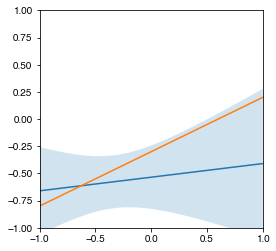

In [29]:
plt.figure(figsize=[4,4])

plt.plot(xs, means)
plt.fill_between(xs, means - np.sqrt(variances), means + np.sqrt(variances), alpha=.2)
plt.plot(xs, get_y(xs, a))

plt.xlim([-1,1])
plt.ylim([-1,1])